In [1]:
################################
# FLO Unsupervised Learning Customer Segmentation
################################

################################
# FLO wants to segment its customers and determine marketing strategies according to these segments. 
# To this end, the behaviors of the customers will be defined and groups will be formed according to the 
# clusters in these behaviors.
################################

################################
# The dataset consists of the information obtained from the past shopping behaviors of customers who made their last purchases from Flo as OmniChannel (both online and offline shopper) in the years 2020 - 2021.
# 12 Variable 19,945 Observations 2.7MB
# master_id: Unique client number
# order_channel: Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)
# last_order_channel: The channel where the last purchase was made
# first_order_date: Date of the customer's first purchase
# last_order_date: The date of the customer's last purchase
# last_order_date_online: The date of the last purchase made by the customer on the online platform
# last_order_date_offline: The date of the last purchase made by the customer on the offline platform
# order_num_total_ever_online: The total number of purchases made by the customer on the online platform
# order_num_total_ever_offline: Total number of purchases made by the customer offline
# customer_value_total_ever_offline: The total price paid by the customer for offline purchases
# customer_value_total_ever_online: The total price paid by the customer for their online shopping
# interested_in_categories_12: List of categories the customer has purchased from in the last 12 months
################################

import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 400)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

/tmp/ipykernel_20/1230818156.py:26: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dataframe.quantile([0, 0.05, 0.50, 0.75, 0.95, 0.99, 1]).T)


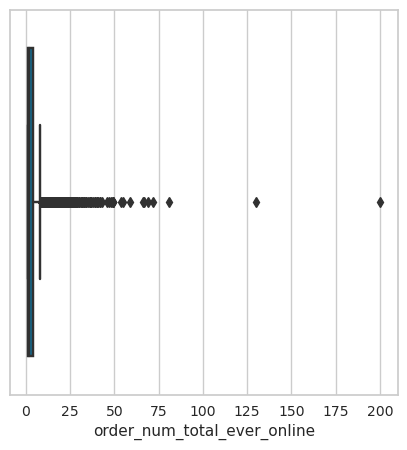

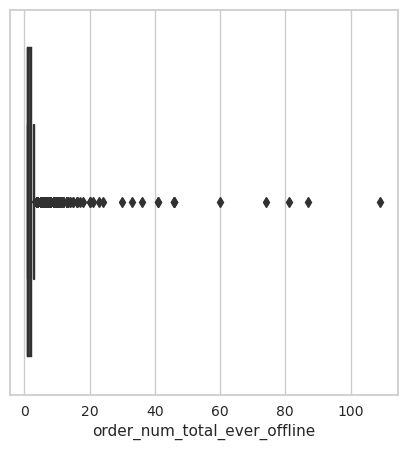

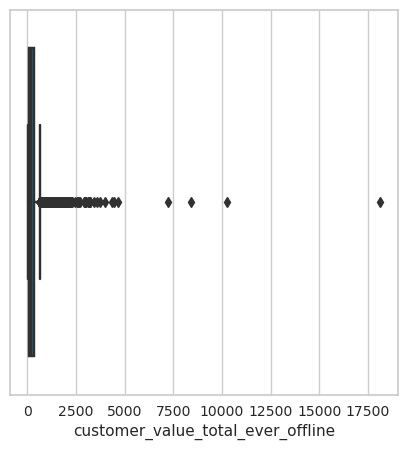

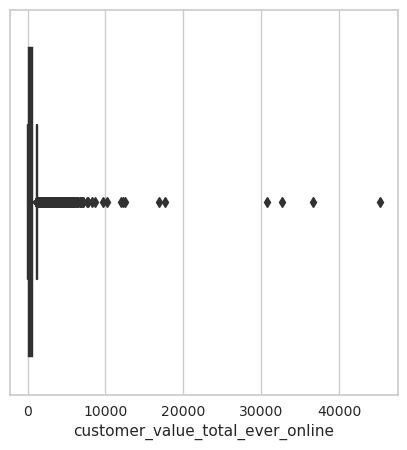

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online     

/tmp/ipykernel_20/1230818156.py:26: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dataframe.quantile([0, 0.05, 0.50, 0.75, 0.95, 0.99, 1]).T)


(19945, 16)

In [2]:
################################
# Task 1: Preparing the Data
################################

################################
# Step 1: Read the flo_data_20K.csv data.
################################

df_ = pd.read_csv("/kaggle/input/flo-data-20k/flo_data_20k.csv")
df = df_.copy()
df.head()
df.info()

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.75, 0.95, 0.99, 1]).T)

check_df(df)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=4, car_th=20)

def boxplot_outliers(dataframe, col_name):
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=dataframe[col_name])
    plt.show(block=True)

for col in num_cols:
    boxplot_outliers(df, col)

# sns.boxplot(x = df['order_num_total_ever_online'])
# plt.show(block=True)
# sns.boxplot(x = df['order_num_total_ever_offline'])
# plt.show(block=True)
# sns.boxplot(x = df['customer_value_total_ever_offline'])
# plt.show(block=True)
# sns.boxplot(x = df['customer_value_total_ever_online'])
# plt.show(block=True)


# Define the outlier_thresholds and replace_with_thresholds functions required to suppress outliers.

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# alt ve üst değerleri yuvarlar max ve min değerlere göre
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)


# Set the variables "order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online"
           # suppress outliers if any.
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")
df.head()

check_df(df)

################################
# Step 2: Select the variables you will use when segmenting the customers.
# Note: You can create new variables such as Tenure (Customer's age), Recency (how many days ago he last shopped).
################################

df['tenure'] = (pd.to_datetime('today') - pd.to_datetime(df['first_order_date'])).dt.days
# It is the time elapsed since the customer's first contact with the e-commerce site/store.
# It can be found by subtracting the minimum contact date from today.

df['recency'] = (pd.to_datetime('today') - pd.to_datetime(df['last_order_date'])).dt.days

# It gives information such as how long the customer has received service from the website/store, and how long he has been a member.
# Calculation is usually obtained by subtracting the last subscription date/last order date from today.

df['frequency'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
# It is the metric that shows how often the customer makes a purchase and how often he logs into the site.
# Usually results in counting the order number/order code.

df['monetary'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']

# It is the sum of the customer's expenses. The turnover it brings to the e-commerce site,
# is also defined as the revenue collected after the services received.

df.info()
df.head()
df.shape

In [3]:
################################
# Görev 2: K-Means ile Müşteri Segmentasyonu
################################

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
                
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=4, car_th=20)

df[num_cols].describe().T


def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)


for col in cat_cols:
    cat_summary(df, col, plot=False)


def one_hot_encoder(df, categorical_cols, drop_first=False):
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
    return df

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.shape
df.head()

Observations: 19945
Variables: 16
cat_cols: 2
num_cols: 8
cat_but_car: 6
num_but_cat: 0
             order_channel  Ratio
Android App           9495  47.61
Mobile                4882  24.48
Ios App               2833  14.20
Desktop               2735  13.71
##########################################
             last_order_channel  Ratio
Android App                6783  34.01
Offline                    6608  33.13
Mobile                     3172  15.90
Ios App                    1696   8.50
Desktop                    1686   8.45
##########################################


,master_id,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,tenure,recency,frequency,monetary,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,last_order_channel_Desktop,last_order_channel_Ios App,last_order_channel_Mobile,last_order_channel_Offline
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],998,879,5.00,939.37,0,0,0,0,0,0,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2358,889,21.00,2013.55,0,0,0,0,0,1,0
2,69b69676-1a40-11ea-941b-000d3a38a36f,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",1336,970,5.00,585.32,0,0,0,0,0,0,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",930,919,2.00,121.97,0,0,0,0,0,0,0
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],1452,870,2.00,209.98,1,0,0,1,0,0,0


In [4]:
################################
# Step 1: Standardize the variables.
################################

sc = MinMaxScaler((0, 1))
df_new = sc.fit_transform(df[num_cols])
df_new = pd.DataFrame(df_new, columns=num_cols)
df_new.info()
df_new.shape
df_new = df_new.merge(df.iloc[:, -7:], left_index=True, right_index=True)

df_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   order_num_total_ever_online        19945 non-null  float64
 1   order_num_total_ever_offline       19945 non-null  float64
 2   customer_value_total_ever_offline  19945 non-null  float64
 3   customer_value_total_ever_online   19945 non-null  float64
 4   tenure                             19945 non-null  float64
 5   recency                            19945 non-null  float64
 6   frequency                          19945 non-null  float64
 7   monetary                           19945 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,last_order_channel_Desktop,last_order_channel_Ios App,last_order_channel_Mobile,last_order_channel_Offline
0,0.06,0.00,0.04,0.10,0.07,0.25,0.05,0.10,0,0,0,0,0,0,1
1,0.38,0.07,0.05,0.24,0.51,0.28,0.35,0.22,0,0,0,0,0,1,0
2,0.04,0.07,0.06,0.05,0.18,0.50,0.05,0.06,0,0,0,0,0,0,0
3,0.00,0.00,0.01,0.01,0.05,0.36,0.00,0.01,0,0,0,0,0,0,0
4,0.00,0.00,0.01,0.02,0.22,0.23,0.00,0.02,1,0,0,1,0,0,0


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

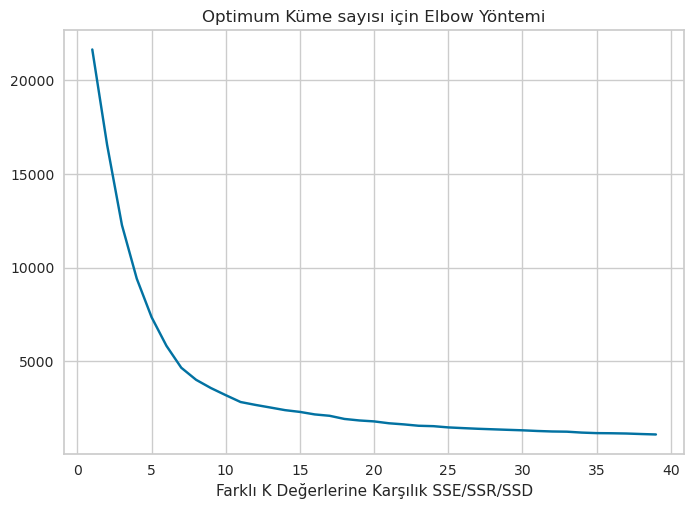

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

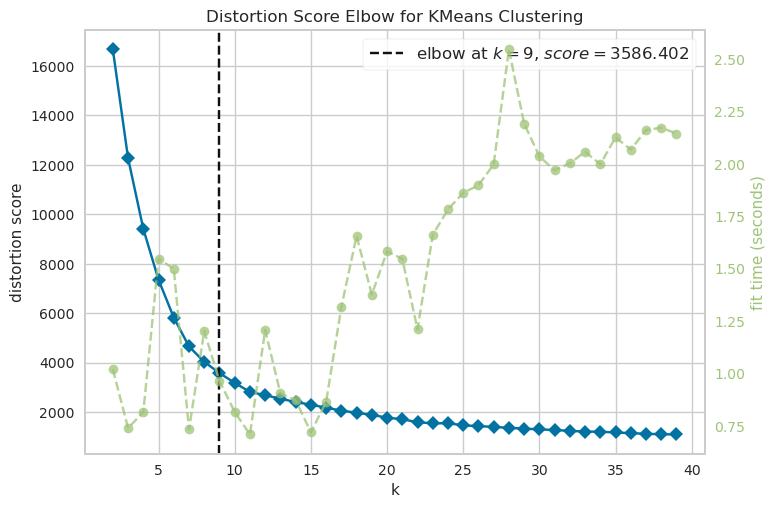

9

In [5]:
################################
# Step 2: Determine the optimum number of clusters. Determination of the Optimum Number of Clusters
################################

kmeans = KMeans()
ssd = []
K = range(1, 40)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df_new)
    ssd.append(kmeans.inertia_)

kmeans.get_params()
kmeans.cluster_centers_
len(kmeans.labels_)
kmeans.inertia_


plt.plot(K, ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show()

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 40))
elbow.fit(df_new)
elbow.show(block=True)

elbow.elbow_value_

In [6]:
################################
# Step 3: Build your model and segment your customers
################################

kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df_new)

kmeans.n_clusters
kmeans.cluster_centers_
kmeans.labels_

# Etiketlerin değişken atamasını yapıyoruz.
clusters_kmeans = kmeans.labels_

# Mevcut DF içerisine küme sayılarını ekliyoruz.
df["cluster"] = clusters_kmeans

df["cluster"] = df["cluster"] + 1
df.head()


# Kümelere göre dağılımını kontrol edelim
def Ratio_(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

Ratio_(df, "cluster")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   cluster  Ratio
2     4452  22.32
1     2768  13.88
8     2498  12.52
7     2358  11.82
5     1933   9.69
3     1871   9.38
6     1686   8.45
4     1535   7.70
9      844   4.23
##########################################


In [7]:
################################
# Step 4: Analyze each segment statistically.
################################

df.groupby("cluster").agg(["mean", "median", "count", "sum"]).T

/tmp/ipykernel_20/1911214133.py:5: FutureWarning: ['master_id', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'interested_in_categories_12'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("cluster").agg(["mean", "median", "count", "sum"]).T


cluster                                           1          2          3          4          5          6          7          8          9
order_num_total_ever_online       mean         2.40       4.22       2.13       1.75       3.76       3.86       2.65       2.95       2.61
                                  median       1.00       3.00       1.00       1.00       2.00       2.00       2.00       2.00       2.00
                                  count     2768.00    4452.00    1871.00    1535.00    1933.00    1686.00    2358.00    2498.00     844.00
                                  sum       6647.00   18770.00    3993.00    2679.00    7270.00    6508.00    6246.00    7357.00    2199.00
order_num_total_ever_offline      mean         1.61       1.81       2.25       2.14       1.68       1.65       2.39       1.60       2.32
                                  median       1.00       1.00       2.00       2.00       1.00       1.00       2.00       1.00       2.00
                                  count     2768.00    4452.00    1871.00    1535.00    1933.00    1686.00    2358.00    2498.00     844.00
                                  sum       4450.00    8057.00    4206.00    3288.00    3249.00    2785.00    5633.00    3995.00    1957.00
customer_value_total_ever_offline mean       206.64     225.82     306.37     312.20     222.65     216.49     341.24     195.46     363.18
                                  median     149.98     159.98     230.95     240.46     159.99     150.47     249.99     139.99     259.97
                                  count     2768.00    4452.00    1871.00    1535.00    1933.00    1686.00    2358.00    2498.00     844.00
                                  sum     571975.49 1005333.40  573218.60  479221.41  430375.90  365001.02  804655.29  488267.23  306522.39
customer_value_total_ever_online  mean       375.57     684.08     276.53     222.67     657.78     624.80     406.77     468.35     437.11
                                  median     235.97     428.54     183.73     149.99     423.69     359.54     242.28     309.47     280.97
                                  count     2768.00    4452.00    1871.00    1535.00    1933.00    1686.00    2358.00    2498.00     844.00
                                  sum    1039567.54 3045511.97  517386.42  341796.93 1271489.48 1053419.20  959160.28 1169927.11  368920.78
tenure                            mean      1499.10    1494.69    1726.45    2155.84    1520.60    1645.47    1480.68    1529.14    1481.96
                                  median    1411.00    1417.00    1588.00    2065.00    1422.00    1456.00    1373.00    1426.00    1361.00
                                  count     2768.00    4452.00    1871.00    1535.00    1933.00    1686.00    2358.00    2498.00     844.00
                                  sum    4149499.00 6654378.00 3230179.00 3309219.00 2939328.00 2774268.00 3491432.00 3819791.00 1250771.00
recency                           mean       906.67     841.92     943.76     956.95     918.35     911.33     923.36    1019.83     935.54
                                  median     892.00     829.00     915.00     936.00     897.00     889.00     894.00    1000.00     910.00
                                  count     2768.00    4452.00    1871.00    1535.00    1933.00    1686.00    2358.00    2498.00     844.00
                                  sum    2509653.00 3748207.00 1765783.00 1468916.00 1775169.00 1536509.00 2177287.00 2547535.00  789593.00
frequency                         mean         4.01       6.03       4.38       3.89       5.44       5.51       5.04       4.54       4.92
                                  median       3.00       5.00       4.00       3.00       4.00       4.00       4.00       4.00       4.00
                                  count     2768.00    4452.00    1871.00    1535.00    1933.00    1686.00    2358.00    2498.00     844.00
                                  sum      11097.00   26827.00    8199.00    596

################################
# TASK 3: CUSTOMER SEGMENTATION WITH HIERARCHICAL CLUSTERING
################################

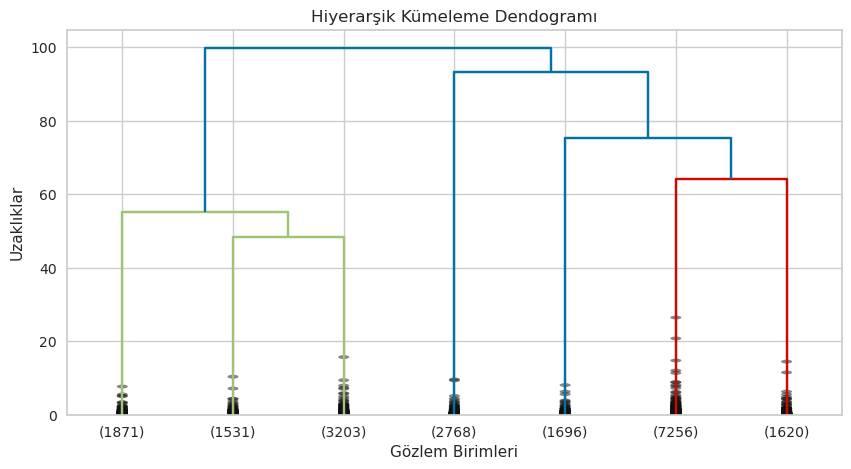

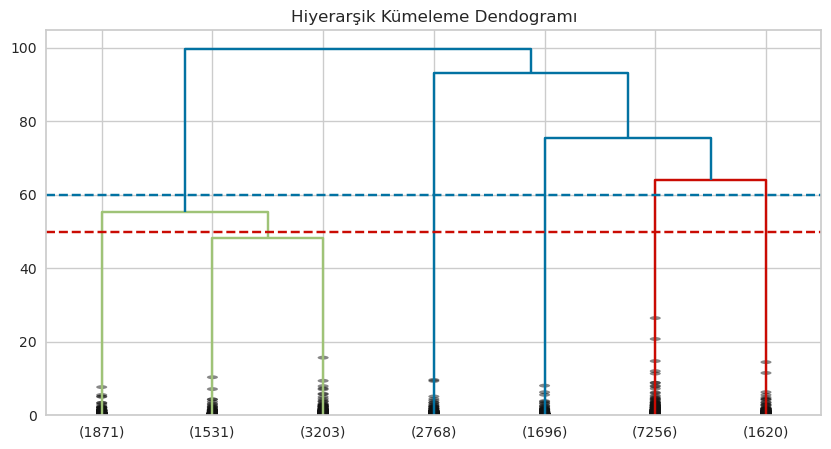

In [8]:

################################
# Step 1: Determine the optimum number of clusters using the dataframe you standardized in Task 2.
################################


hc_ward = linkage(df_new, "ward")

plt.figure(figsize=(10, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_ward,
            truncate_mode="lastp",
            p=7,
            show_contracted=True,
            leaf_font_size=10)
plt.show(block=True)

plt.figure(figsize=(10, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
dend = dendrogram(hc_ward,
                 truncate_mode="lastp",
                  p=7,
                  show_contracted=True,
                  leaf_font_size=10)
plt.axhline(y=60, color="b", linestyle="--")
plt.axhline(y=50, color="r", linestyle="--")
plt.show(block=True)

In [9]:
################################
# Step 2: Build your model and segment your customers.
################################

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=6, linkage="average")

clusters = cluster.fit_predict(df_new)

df["hi_cluster_no"] = clusters

df["hi_cluster_no"] = df["hi_cluster_no"] + 1

df.head()

# Let's check the distribution by clusters
def Ratio_(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)


Ratio_(df, "hi_cluster_no")

   hi_cluster_no  Ratio
1          16425  82.35
2           1883   9.44
3           1621   8.13
6             12   0.06
5              3   0.02
4              1   0.01
##########################################


In [10]:
################################
# Step 3: Analyze each segment statistically.
################################

df.groupby("hi_cluster_no").agg(["mean", "median", "count", "sum"]).T

/tmp/ipykernel_20/2934792595.py:5: FutureWarning: ['master_id', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'interested_in_categories_12'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("hi_cluster_no").agg(["mean", "median", "count", "sum"]).T


hi_cluster_no                                      1          2          3       4        5        6
order_num_total_ever_online       mean          2.94       3.67       3.57   48.00    45.00    36.17
                                  median        2.00       2.00       2.00   48.00    48.00    38.00
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum       48360.00    6909.00    5783.00   48.00   135.00   434.00
order_num_total_ever_offline      mean          1.93       1.69       1.64    1.00     3.67     2.42
                                  median        1.00       1.00       1.00    1.00     3.00     2.00
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum       31726.00    3189.00    2664.00    1.00    11.00    29.00
customer_value_total_ever_offline mean        258.41     225.85     215.30 1263.76   391.08   285.09
                                  median      180.74     159.99     149.99 1263.76   292.93   222.72
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum     4244432.91  425275.52  349004.23 1263.76  1173.25  3421.06
customer_value_total_ever_online  mean        457.79     653.29     564.57 7800.00  5847.54  6443.26
                                  median      269.47     413.97     344.95 7800.00  5404.53  6821.84
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum     7519211.66 1230137.24  915169.02 7800.00 17542.62 77319.17
tenure                            mean       1587.16    1513.94    1638.57 3479.00  2717.67  2601.00
                                  median     1436.00    1422.00    1453.00 3479.00  2801.00  2629.00
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum    26069165.00 2850740.00 2656116.00 3479.00  8153.00 31212.00
recency                           mean        919.04     919.25     911.95  798.00   965.33   881.92
                                  median      896.00     898.00     889.00  798.00   970.00   822.00
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum    15095167.00 1730939.00 1478269.00  798.00  2896.00 10583.00
frequency                         mean          4.88       5.36       5.21   49.00    48.67    38.58
                                  median        4.00       4.00       4.00   49.00    51.00    41.50
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum       80086.00   10098.00    8447.00   49.00   146.00   463.00
monetary                          mean        716.20     879.14     779.87 9063.76  6238.62  6728.35
                                  median      534.91     643.03     561.81 9063.76  5464.52  7010.30
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum    11763644.57 1655412.76 1264173.25 9063.76 18715.87 80740.23
order_channel_Desktop             mean          0.09       0.00       0.74    0.00     0.00     0.33
                                  median        0.00       0.00       1.00    0.00     0.00     0.00
                                  count     16425.00    1883.00    1621.00    1.00     3.00    12.00
                                  sum        1535.00       0.00    1196.00    0.00     0.00     4.00
order_channel_Ios App             mean          0.06       1.00       0.00    1.00     0.67     0.17
                                  median        0.00       1.00       0.00    1.00     1.00     0.00
                                  count     16425.00    1883.